# "Distributed Multinomial Sampling"
> "A distributed algorithm for sampling from a multinomial distribution in O(log d) time, where d is the number of outcomes."

- toc: true
- branch: master
- badges: false
- comments: false
- categories: [probability, sampling, distributed]
- hide: false
- search_exclude: false
- image: images/blog_posts/distributed_multinomial_sampling.png
- redirect_from: blog/distributed_multinomial

Suppose you want to sample from the multinomial distribution, that is, the binomial distribution generalized to more than two outcomes.

The distribution is specified with an integer parameter $N$, specifying the number of independent trials, and a discrete probability vector $\bf p$ of length $d$ specifying the probability of each outcome in each trial. It is the probability distribution of the number of each of the $d$ possible outcomes.

## The sequential solution

Typically, you'd sample from the multinomial by doing repeated binomial sampling; sample from the binomial to determine the number of trials resulting in outcome number 1, i.e., sample $n_1 \sim \text{Bin}(N, p_1)$. Then subtract $n_1$ from the number of trials $N$ and sample from the binomial for the second outcome, $n_2 \sim \text{Bin}(N-n_1, p_2)$, and so on, as follows.

In [4]:
#hide
import numpy as np

In [5]:
def multinomial_sample(N, ps):
    N1 = N
    ns = np.zeros_like(ps)

    for p_i in range(len(ps)):
        n = np.random.binomial(N1, ps[p_i] / ps[p_i:])
        ns[p_i] = n
        N1 -= n

    return ns

How long is that going to take? If you sample from a binomial using NumPy or R, which algorithm is used depends on the parameters. If $N p \le 30$, then an inverse transformation algorithm is used, which takes $\text{O}(N \text{min}(p, 1-p))$. If $N p > 30$, an algorithm called BTPE, which is an approximate sequential acceptance/rejection algorithm, is used. This algorithm is sublinear time, and is "approximately constant time" for $N p > 30$ {% fn 1 %}.

Let's say that binomial sampling is $\text{O}(1)$. Then multinomial sampling by sequential binomial sampling is $\text{O}(d)$, where $d$ is the number of possible outcomes.

{{ 'Binomial random variate generation, Kachitvichyanukul and Schmeiser.' | fndetail: 1 }}

## Can we do better?

What about parallelising the work? Our sequential binomial sampling method doesn't seem very parallelisable, so let's think of a way that does. Another approach to determine the number of trials resulting in the $i$th outcome is to repeatedly bisect the possible outcomes, using binomial sampling each time to sample the number of trials resulting in an outcome in the same half as the outcome we're interested in.

E.g., suppose we have four possible outcomes, with probabilities [0.4, 0.1, 0.2, 0.3], and we want the number of trials resulting in the second outcome. First we sample from the binomial to determine how many trials result in any of the first half of outcomes (with probability 0.5), then we sample from the binomial again to determine the number of those that result in the second outcome (with probability $0.1/(0.4+0.1) = 0.2$). To sample the number of outcomes $i$, for any single $i$, in this way takes $\text{O}(\log d)$.

## Consistency

Now it's just a matter of assigning each outcome to a separate node/computer and doing the work in parallel, right? Not quite. There's quite a bit of shared computation going on between nodes, and they'd better agree on their answers. For example, all nodes sampling for the first half of the possible outcomes first sample from a binomial to determine the number of trials that lead to outcomes in that half, and they should all get the same answer. If they don't, we won't be collectively sampling from a multinomial and our total number of trials, when we sum over the outcomes, won't sum to $N$.

There are two solutions: communication or ensuring consistent random number generator (RNG) states. The first solution would have a single node sample the number of trials leading to one of the first half of outcomes. It would then share this number with a second node, and the two of them would bisect the outcomes again, communicate the results to another two nodes, and so on.

I'll focus here on the consistent RNG solution. The idea is that when any two nodes are asking *exactly the same question* then *their RNGs should be in the same state*. Since in my examples I'll be using NumPy's RNG, I'll be explicitly setting its seed algorithmically. **This is probably a bad idea**. Ideally, you'd be using an RNG that allows you to skip ahead by $n$ states in constant time.

In [7]:
#collapse-show
# Sample the number of N trials resulting in outcome leaf_index with probability ps[leaf_index]
# by repeatedly bisecting the possible outcomes and doing binomial sampling
def multinomial_sample2(N, ps, leaf_index, branch_index=0, base_seed=0):
    if ps.size == 1:
        return N

    # Split the outcomes in half
    split_index = int(np.ceil(0.5 * ps.size))
    # Compute the probability that a trial results in the left half of the outcomes
    left_p = np.sum(ps[:split_index])

    # Set the RNG such that the RNG state depends on where we are in the outcome bisection tree
    # i.e., using the current branch index
    # Algorithmically setting the NumPy RNG state is **probably a bad idea**
    np.random.seed(base_seed + branch_index)

    # Sample from the binomial to determine the number of trials resulting in one of the outcomes on the left
    left_N = np.random.binomial(N, left_p)

    # Recursively call this function, with parameters depending on if the leaf_index outcome is on the left or the right
    # Branches are numbered depth first, so that if we take the left branch then the next branch index is the current + 1
    # and if we take the right branch then the next branch index is the current + 1 + #branch indices in the left subtree
    if leaf_index >= split_index:
        return multinomial_sample2(N - left_N, ps[split_index:]/(1-left_p), leaf_index - split_index, branch_index + split_index, base_seed)
    else:
        return multinomial_sample2(left_N, ps[:split_index]/left_p, leaf_index, branch_index + 1, base_seed)


The following shows the algorithm in action. The boxplots indicate the count for each outcome over a number of trials, while the coloured dots indicate the expected values.

In [8]:
#hide
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [9]:
N = 1000
d = 10
ps = np.random.random(size=d)
ps /= np.sum(ps)
trials = 1000

outcome_counts = np.array([[multinomial_sample2(N, ps, i, j) for i in range(d)] for j in range(trials)])

Total number of events counted = 1000 per trial


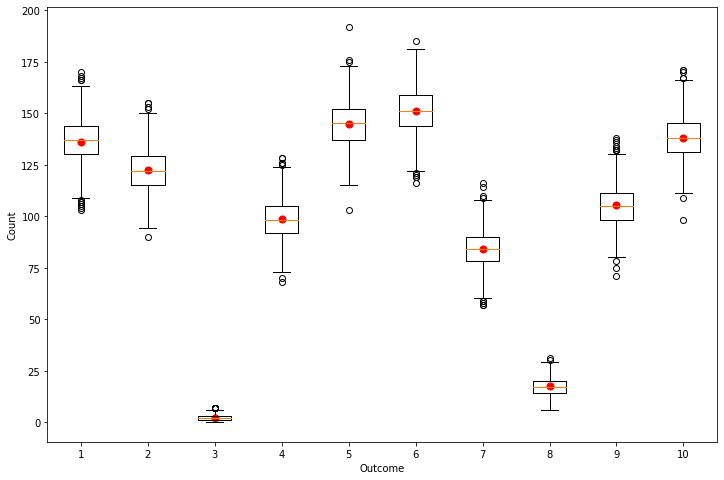

In [10]:
figure = plt.figure(figsize=(12,8))
plt.boxplot(outcome_counts);
plt.scatter(np.arange(1, d+1, 1), N*ps, c="r", s=50);
plt.xlabel("Outcome");
plt.ylabel("Count");

print("Total number of events counted = {} per trial".format(int(np.sum(outcome_counts) / trials)))

## Equal probability case

One problem with the above is that it requires us to compute the sum of the probabilities on the left hand branch each time we bisect the possible outcomes. This effectively adds an $\text{O}(d)$ operation for each node. For the special case that each of the $d$ possible outcomes has the same probability, then we don't have to perform this sum and can do the following instead. (This is also useful if the *majority* of outcomes have the same probability.)

In [11]:
#collapse-show
# Sample the number of N trials resulting in outcome leaf_index, where each outcome has the same probability,
# by repeatedly bisecting the possible outcomes and doing binomial sampling
def multinomial_sample3(N, d, leaf_index, branch_index=0, base_seed=0):
    if d == 1:
        return N

    # Split the outcomes in half
    split_index = int(np.ceil(0.5 * d))
    # Compute the probability that a trial results in the left half of the outcomes
    left_p = float(split_index) / d

    # Set the RNG such that the RNG state depends on where we are in the outcome bisection tree
    # i.e., using the current branch index
    # Algorithmically setting the NumPy RNG state is **probably a bad idea**
    np.random.seed(base_seed + branch_index)

    # Sample from the binomial to determine the number of trials resulting in one of the outcomes on the left
    left_N = np.random.binomial(N, left_p)

    # Recursively call this function, with parameters depending on if the leaf_index outcome is on the left or the right
    # Branches are numbered depth first, so that if we take the left branch then the next branch index is the current + 1
    # and if we take the right branch then the next branch index is the current + 1 + #branch indices in the left subtree
    if leaf_index >= split_index:
        return multinomial_sample3(N - left_N, d-split_index, leaf_index - split_index, branch_index + split_index, base_seed)
    else:
        return multinomial_sample3(left_N, split_index, leaf_index, branch_index + 1, base_seed)

Total number of events counted = 1000 per trial


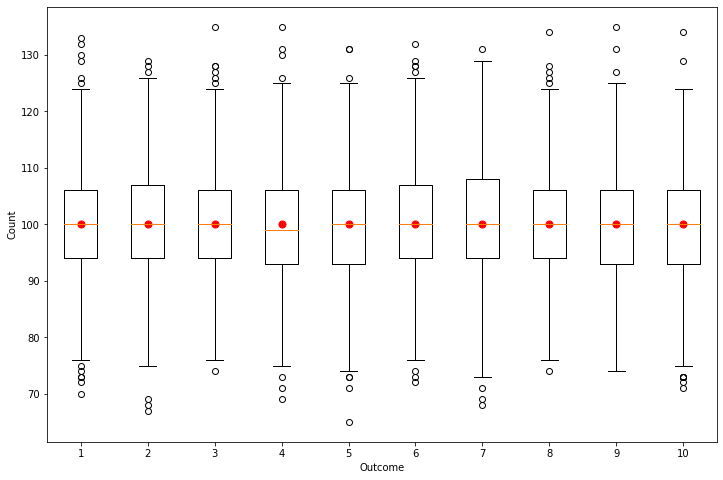

In [12]:
N = 1000
d = 10
trials = 1000

outcome_counts = np.array([[multinomial_sample3(N, d, i, j) for i in range(d)] for j in range(trials)])

figure = plt.figure(figsize=(12,8))
plt.boxplot(outcome_counts);
plt.scatter(np.arange(1, d+1, 1), N/float(d) * np.ones(d), c="r", s=50);
plt.xlabel("Outcome");
plt.ylabel("Count");

print("Total number of events counted = {} per trial".format(int(np.sum(outcome_counts) / trials)))

## When might this be useful?

The above lets you replace an $\text{O}(d)$ time sampling algorithm with a $\text{O}(d \log d)$ one that allows the work to be distributed amongst $d$ independent nodes, allowing the sampling to be done in $\text{O}(\log d)$ time.

Is this likely to be practically useful? If you need to sample from a multinomial where $d$, the number of possible outcomes, is so large that an algorithm linear in $d$ is too slow, well, you're unlikely to have a $d$-processor machine or a $d$-machine cluster available to you.

If you have $m$ processing nodes available, $m < d$, then you can split the outcomes into $m$ blocks of $d/m$, and use the above algorithm to sample the number of trials leading to an outcome in each of the blocks in $\text{O}(\log m)$ time. You can then use repeated binomial sampling within each node to sample the number of trials for each outcome in that block in $\text{O}(d/m)$ time. Since for $d >> m$, the work is going to be dominated by the $\text{O}(d/m)$ part, this effectively divides the sampling time by the number of nodes.